In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from data.data_preprocessing import df, label_encoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Split data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['intent_encoded'], test_size=0.2, random_state=42, stratify=df['intent_encoded'])

# Vectorize data

In [53]:
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Define models

In [21]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Train models

In [ ]:
results = {}

for model_name, model in models.items():
    model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)

    results[model_name] = {
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

# Evaluate models

In [50]:
metrics = []

for model_name, result in results.items():
    precision = result['report']['weighted avg']['precision']
    recall = result['report']['weighted avg']['recall']
    f1 = result['report']['weighted avg']['f1-score']
    acc = result['accuracy']
    metrics.append({
        'Model': model_name,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1-Score': round(f1, 3),
        'Accuracy': round(acc, 3)
    })

pd.DataFrame(metrics)

,Model,Precision,Recall,F1-Score,Accuracy
0,Multinomial Naive Bayes,0.922,0.917,0.916,0.917
1,Logistic Regression,0.953,0.950,0.951,0.950
2,Support Vector Machine,0.960,0.959,0.959,0.959
3,Random Forest,0.944,0.942,0.942,0.942


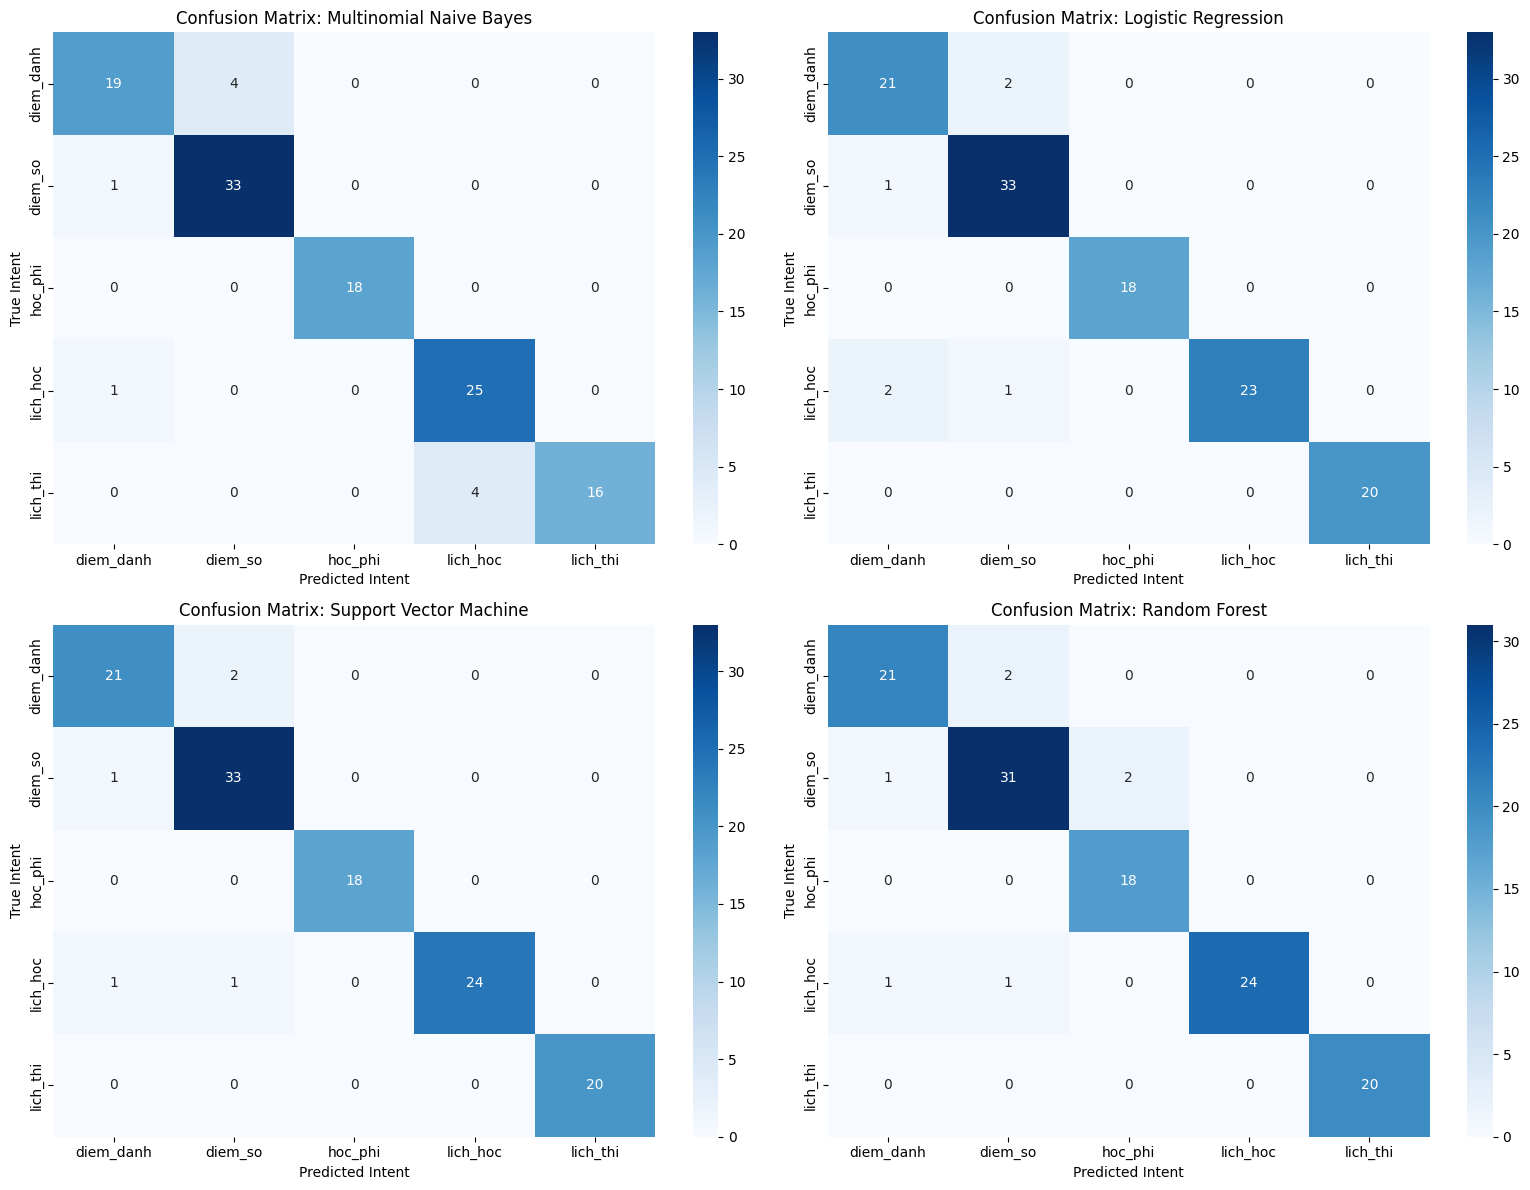

In [55]:
intent_classes = label_encoder.inverse_transform(np.unique(y_test))
plt.figure(figsize=(16,12))
for i, (model_name, results_) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    sns.heatmap(results_['confusion'], annot=True, fmt="d", cmap="Blues", xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted Intent')
    plt.ylabel('True Intent')
    plt.title(f'Confusion Matrix: {model_name}')
plt.tight_layout()
plt.show()

# Save model

In [ ]:
joblib.dump(vectorizer, 'models/vectorizer.pkl')

['models/vectorizer.pkl']